## Librerías

In [1]:
# !pip install torch torchvision

In [2]:
# !pip install tf-keras

*Keras*

In [3]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import gzip

*Sklearn*

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

*Datos + Viz*

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

In [6]:
from PIL import Image
import os
import torch

In [7]:
from datasets import Dataset
from transformers import AutoImageProcessor

HuggingFace

In [8]:
#from huggingface_hub import hf_hub_download

In [9]:
calc = pd.read_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/calc.csv')
mass = pd.read_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/mass.csv')

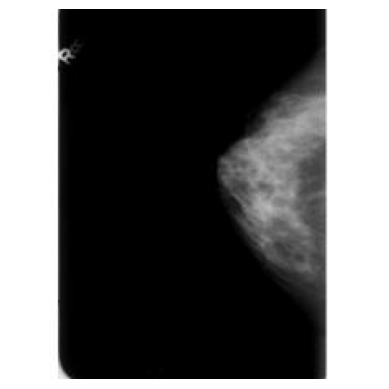

In [10]:
image_path = calc.loc[0, 'image_file_path_red']  # acceder a la ruta del archivo
image = mpimg.imread(image_path)  # leer la imagen

plt.imshow(image, cmap='gray')  # o sin cmap si es RGB
plt.axis('off')  # opcional, para ocultar ejes
plt.show()

In [11]:
# Crear la columna 'target' con categoría 1=maligno, 0 = benigno
calc['target'] = calc['pathology'].apply(lambda x: 1 if x == 'MALIGNANT' else 0)
mass['target'] = mass['pathology'].apply(lambda x: 1 if x == 'MALIGNANT' else 0)

# Añadir columna 'type'
calc['type'] = 'calc'
mass['type'] = 'mass'

# Seleccionar solo columnas necesarias y unificarlas
df = pd.concat([
    calc[['type', 'image_file_path_red', 'target']],
    mass[['type', 'image_file_path_red', 'target']]
], ignore_index=True)

# Verificar resultado
print(df.head())
print(df['target'].value_counts())
print(df['type'].value_counts())


   type                              image_file_path_red  target
0  calc  processed_images\calc\image_file_path\1-188.jpg       1
1  calc  processed_images\calc\image_file_path\1-189.jpg       1
2  calc  processed_images\calc\image_file_path\1-190.jpg       0
3  calc  processed_images\calc\image_file_path\1-191.jpg       0
4  calc  processed_images\calc\image_file_path\1-192.jpg       0
target
0    1589
1    1268
Name: count, dtype: int64
type
mass    1592
calc    1265
Name: count, dtype: int64


In [12]:
df = df.rename(columns={"image_file_path_red": "image", "target": "label"})

In [13]:
df.head()

,type,image,label
0,calc,processed_images\calc\image_file_path\1-188.jpg,1
1,calc,processed_images\calc\image_file_path\1-189.jpg,1
2,calc,processed_images\calc\image_file_path\1-190.jpg,0
3,calc,processed_images\calc\image_file_path\1-191.jpg,0
4,calc,processed_images\calc\image_file_path\1-192.jpg,0


In [14]:
df.to_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/df.csv', index=False)

In [15]:
#Convertir a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)

In [16]:
import transformers
print(transformers.__version__)

4.52.2


## ViTForImageClassification

In [17]:
# Cargar modelo y preprocesador
from transformers import ViTImageProcessor, ViTForImageClassification

checkpoint = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(checkpoint)
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Este mensaje es normal, ahora se debe hacer fine-tune para que el modelo para que aprenda a clasificar correctamente las 2

In [18]:
# carga + preprocesamiento
def transform(example):
    image = Image.open(example["image"]).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    inputs["label"] = example["label"]
    return {"pixel_values": inputs["pixel_values"][0], "label": inputs["label"]}

# Preprocesar dataset
hf_dataset = hf_dataset.map(transform)

Map:   0%|          | 0/2857 [00:00<?, ? examples/s]

In [19]:
# train test split
split = hf_dataset.train_test_split(test_size=0.2)
train_ds = split["train"]
test_ds = split["test"]

In [20]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer

In [21]:

# entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    # evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

In [22]:
import evaluate


In [23]:
# Métrica
metric = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

In [52]:
# Entrenar
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)


trainer.train()

c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.826200
20,0.802200
30,0.849600
40,0.743600
50,0.710200
60,0.745800
70,0.685100
80,0.683600
90,0.706300
100,0.698000


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1430, training_loss=0.6756643602064439, metrics={'train_runtime': 5050.2846, 'train_samples_per_second': 2.262, 'train_steps_per_second': 0.283, 'total_flos': 8.853459813467136e+17, 'train_loss': 0.6756643602064439, 'epoch': 5.0})

In [53]:
eval_results = trainer.evaluate()
print(eval_results)


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7822157740592957, 'eval_accuracy': 0.5052447552447552, 'eval_runtime': 151.7957, 'eval_samples_per_second': 3.768, 'eval_steps_per_second': 0.474, 'epoch': 5.0}


In [54]:
# obtener las predicciones con etiquetas reales, para luego hacer análisis más detallado

predictions_output = trainer.predict(test_ds)

# Obtener predicciones y etiquetas
pred_logits = predictions_output.predictions  # salida del modelo (logits)
pred_labels = np.argmax(pred_logits, axis=1)  # etiquetas predichas (0 o 1)
true_labels = predictions_output.label_ids    # etiquetas reales

# Calcular accuracy (ya lo hace trainer, pero si quieres hacerlo manual)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Más detalle: reporte clasificación
print(classification_report(true_labels, pred_labels, target_names=["Benigno", "Maligno"]))


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.5052
              precision    recall  f1-score   support

     Benigno       0.53      0.68      0.60       310
     Maligno       0.44      0.30      0.36       262

    accuracy                           0.51       572
   macro avg       0.49      0.49      0.48       572
weighted avg       0.49      0.51      0.49       572



Un accuracy tan cercano a 0,5 es prácticamente un clasificador aleatorio. Por otro lado, hay una diferencia grande en recall (0.68 en benigno y 0.30 para maligno), por lo que parece que el modelo es más propenso a precedir benigno.

Posibles mejoras para el modelo: 

1. Balancear clases en entrenamiento: weighted loss para penalizar más los errores en clase Maligno.

2. Aumentar datos (Data Augmentation): transformaciones (rotación, zoom, flips) 

3. Ajustar hiperparámetros: aumentar epochs por ejemplo

4. Probar otros modelos 

1. Weight loss para balancear clases:

In [29]:
import torch
import torch.nn as nn
from transformers import Trainer

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) #para penalizar más los errores en la clase minoritaria.
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Crear tensor con pesos: Clase 0 (benigno): peso 1.0, Clase 1 (maligno): peso 3.0
class_weights = torch.tensor([1.0, 3.0]).to(model.device) 


2. Data Augmentation

In [30]:
from torchvision import transforms

# Definir transformaciones para data augmentation (aplicarlas solo en train)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # rotar hasta 15 grados
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # zoom y recorte
    transforms.ToTensor()
])

# Para validación solo normalización + ToTensor
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Modifica la función transform para aplicar las transformaciones:

def transform_train(example):
    image = Image.open(example["image"]).convert("RGB")
    image = train_transforms(image)
 
    inputs = processor(images=image, return_tensors="pt")
    inputs["label"] = example["label"]
    return {"pixel_values": inputs["pixel_values"][0], "label": inputs["label"]}

def transform_val(example):
    image = Image.open(example["image"]).convert("RGB")
    image = val_transforms(image)
    inputs = processor(images=image, return_tensors="pt")
    inputs["label"] = example["label"]
    return {"pixel_values": inputs["pixel_values"][0], "label": inputs["label"]}



3. Ajustar hiperparámetros

In [31]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,  # antes 5, ahora más
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from transformers import (
    Trainer,
    TrainingArguments,
    ViTForImageClassification,
    ViTImageProcessor,
)
from torchvision import transforms
from datasets import load_dataset  # solo si usas Hugging Face datasets
from PIL import Image
import evaluate

# 1. Configuración del modelo y procesador
checkpoint = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(checkpoint)
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
)

# 2. Data Augmentation y transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
])

def transform_train(example):
    image = Image.open(example["image"]).convert("RGB")
    image = train_transforms(image)
    inputs = processor(images=image, return_tensors="pt")
    inputs["label"] = example["label"]
    return {
        "pixel_values": inputs["pixel_values"][0],  # quitar batch dim extra
        "label": inputs["label"]
    }

def transform_val(example):
    image = Image.open(example["image"]).convert("RGB")
    image = val_transforms(image)
    inputs = processor(images=image, return_tensors="pt")
    inputs["label"] = example["label"]
    return {
        "pixel_values": inputs["pixel_values"][0],
        "label": inputs["label"]
    }


# 4. Aplicar transformaciones
hf_dataset_train = hf_dataset.map(transform_train)
hf_dataset_val = hf_dataset.map(transform_val)

# 5. Dividir el dataset para train/test
split = hf_dataset_train.train_test_split(test_size=0.2)
train_ds = split["train"]
test_ds = split["test"]

# 6. Definir clase Trainer personalizada con pesos
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 7. Definir pesos para clases desbalanceadas (ajusta según tus datos reales)
class_weights = torch.tensor([1.0, 3.0]).to(model.device)

# 8. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,

)

# 9. Métricas
metric = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

# 10. Entrenador
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

# 11. Entrenamiento
trainer.train()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2857 [00:00<?, ? examples/s]

Map:   0%|          | 0/2857 [00:00<?, ? examples/s]

Step,Training Loss
10,0.789200
20,0.706400
30,0.615900
40,0.597800
50,0.712900
60,0.731600
70,0.691900
80,0.664700
90,0.651300
100,0.676000


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\swatc\anaconda3\envs\conda310\lib\s

TrainOutput(global_step=4290, training_loss=0.25954946779523796, metrics={'train_runtime': 15278.3833, 'train_samples_per_second': 2.243, 'train_steps_per_second': 0.281, 'total_flos': 2.656037944040141e+18, 'train_loss': 0.25954946779523796, 'epoch': 15.0})

In [36]:
eval_results_2 = trainer.evaluate()
print(eval_results_2)

c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 4.815617084503174, 'eval_accuracy': 0.5122377622377622, 'eval_runtime': 105.413, 'eval_samples_per_second': 5.426, 'eval_steps_per_second': 0.683, 'epoch': 15.0}


In [37]:
# obtener las predicciones con etiquetas reales, para luego hacer análisis más detallado

predictions_output_2 = trainer.predict(test_ds)

# Obtener predicciones y etiquetas
pred_logits = predictions_output_2.predictions  # salida del modelo (logits)
pred_labels = np.argmax(pred_logits, axis=1)  # etiquetas predichas (0 o 1)
true_labels = predictions_output_2.label_ids    # etiquetas reales

# Calcular accuracy (ya lo hace trainer, pero si quieres hacerlo manual)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Más detalle: reporte clasificación
print(classification_report(true_labels, pred_labels, target_names=["Benigno", "Maligno"]))


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.5122
              precision    recall  f1-score   support

     Benigno       0.56      0.64      0.60       325
     Maligno       0.42      0.34      0.38       247

    accuracy                           0.51       572
   macro avg       0.49      0.49      0.49       572
weighted avg       0.50      0.51      0.50       572



In [38]:
# import pickle

path_pkl = "C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/models/vit_model_2.pkl"

# with open(path_pkl, "wb") as f:
#     pickle.dump(model, f)

## Resnet

In [39]:
import torch
import torch.nn as nn
import torchvision.models as models

# Cargar ResNet50 preentrenada en ImageNet
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Adaptar la primera capa: imágenes en escala de grises 
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Reemplazar la capa final (FC) por una para clasificación binaria
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\swatc/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 72.0MB/s]


In [40]:
from torchvision import transforms
from PIL import Image

#Data Augmentation

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # si tus imágenes son RGB pero quieres 1 canal
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalización para 1 canal
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [41]:
# Transform y balanceo de clases

from torch.utils.data import Dataset, DataLoader
import os

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["image"]
        label = int(self.df.iloc[idx]["label"])
        image = Image.open(image_path).convert("RGB")  # si es PNG en gris, usa .convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label


In [43]:
#Pesos para clases desbalanceadas
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label"]),
    y=df["label"]
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [46]:
#Train, test, val:

# Primero divide en train + temp
df_trainval, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Luego divide df_trainval en train y val
df_train, df_val = train_test_split(
    df_trainval,
    test_size=0.2,  # esto será 20% de 80%, es decir, 16% del total
    stratify=df_trainval["label"],
    random_state=42
)


In [48]:
#Entrenamiento

from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Asegúrate de tener esto ya cargado:
# df_train, df_val, df_test

# 1. Dataset personalizado
train_dataset = CustomImageDataset(df_train, transform=train_transforms)
val_dataset = CustomImageDataset(df_val, transform=val_transforms)

# 2. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# 3. Modelo y dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# 4. Pérdida y optimizador
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = Adam(resnet.parameters(), lr=1e-4)

# 5. Entrenamiento
for epoch in range(10):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validación
    resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1 | Train Loss: 0.7287, Train Acc: 0.5131 | Val Loss: 0.7611, Val Acc: 0.5558
Epoch 2 | Train Loss: 0.7151, Train Acc: 0.4907 | Val Loss: 0.6962, Val Acc: 0.4639
Epoch 3 | Train Loss: 0.7070, Train Acc: 0.5284 | Val Loss: 0.7055, Val Acc: 0.4945
Epoch 4 | Train Loss: 0.7061, Train Acc: 0.5038 | Val Loss: 0.7076, Val Acc: 0.4420
Epoch 5 | Train Loss: 0.7059, Train Acc: 0.4754 | Val Loss: 0.6937, Val Acc: 0.4748
Epoch 6 | Train Loss: 0.7001, Train Acc: 0.5230 | Val Loss: 0.6932, Val Acc: 0.5011
Epoch 7 | Train Loss: 0.6950, Train Acc: 0.5334 | Val Loss: 1.7846, Val Acc: 0.4726
Epoch 8 | Train Loss: 0.7031, Train Acc: 0.5175 | Val Loss: 0.6965, Val Acc: 0.4945
Epoch 9 | Train Loss: 0.6991, Train Acc: 0.5060 | Val Loss: 0.6945, Val Acc: 0.4551
Epoch 10 | Train Loss: 0.6968, Train Acc: 0.5033 | Val Loss: 0.6943, Val Acc: 0.4573


In [49]:
#Evaluación

from sklearn.metrics import accuracy_score

resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation accuracy: {accuracy:.4f}")


Validation accuracy: 0.4573


In [50]:
#resnet 2:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from PIL import Image
import os

# 1. Dividir el dataset
df_trainval, df_test = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.2, stratify=df_trainval["label"], random_state=42)

# 2. Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Para pasar de 1 canal a 3
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalización simple
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 3. Dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["image"]
        label = self.df.iloc[idx]["label"]
        image = Image.open(image_path).convert("L")  # asegúrate de abrir como escala de grises
        if self.transform:
            image = self.transform(image)
        return image, label

# 4. Pesos de clase
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df_train["label"]),
    y=df_train["label"]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# 5. Datasets y loaders
train_dataset = CustomImageDataset(df_train, transform=train_transforms)
val_dataset = CustomImageDataset(df_val, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 6. Modelo
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, len(np.unique(df["label"])))
resnet = resnet.to(device)

# 7. Optimización
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# 8. Entrenamiento con validación
num_epochs = 15

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validación
    resnet.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Validation Accuracy: {acc:.4f}")



c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 | Loss: 0.7342 | Validation Accuracy: 0.5361
Epoch 2/15 | Loss: 0.7235 | Validation Accuracy: 0.4858
Epoch 3/15 | Loss: 0.7122 | Validation Accuracy: 0.4858
Epoch 4/15 | Loss: 0.7088 | Validation Accuracy: 0.5602
Epoch 5/15 | Loss: 0.6941 | Validation Accuracy: 0.5361
Epoch 6/15 | Loss: 0.6963 | Validation Accuracy: 0.4880
Epoch 7/15 | Loss: 0.6865 | Validation Accuracy: 0.5470
Epoch 8/15 | Loss: 0.6826 | Validation Accuracy: 0.5252
Epoch 9/15 | Loss: 0.6817 | Validation Accuracy: 0.5186
Epoch 10/15 | Loss: 0.6850 | Validation Accuracy: 0.5492
Epoch 11/15 | Loss: 0.6808 | Validation Accuracy: 0.5011
Epoch 12/15 | Loss: 0.6784 | Validation Accuracy: 0.5077
Epoch 13/15 | Loss: 0.6839 | Validation Accuracy: 0.4726
Epoch 14/15 | Loss: 0.6698 | Validation Accuracy: 0.5164
Epoch 15/15 | Loss: 0.6601 | Validation Accuracy: 0.4748



✅ Test Accuracy: 0.4808

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.6000    0.1981    0.2979       318
           1     0.4540    0.8346    0.5881       254

    accuracy                         0.4808       572
   macro avg     0.5270    0.5164    0.4430       572
weighted avg     0.5352    0.4808    0.4267       572



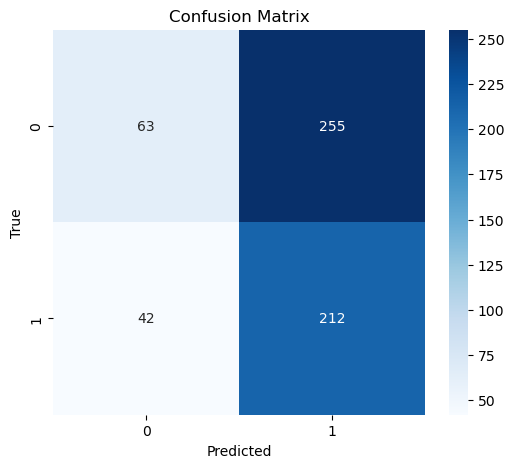

In [51]:
#evaluacion

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Dataset y loader de test
test_dataset = CustomImageDataset(df_test, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=16)

# 2. Evaluación
resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Métricas
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# 4. Reporte de clasificación
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# 5. Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df["label"]), yticklabels=np.unique(df["label"]))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## VGG16 

In [53]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical


In [61]:
#Train/test split

# 1. Divide en train+val y test (20% test)
df_trainval, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# 2. Divide trainval en train y val (20% de trainval → 16% del total)
df_train, df_val = train_test_split(
    df_trainval,
    test_size=0.2,
    stratify=df_trainval["label"],
    random_state=42
)

# Resultado:
print(f"Train: {len(df_train)} imágenes")
print(f"Val:   {len(df_val)} imágenes")
print(f"Test:  {len(df_test)} imágenes")


Train: 1828 imágenes
Val:   457 imágenes
Test:  572 imágenes


In [62]:
# Asegúrate de que los labels sean enteros (0 y 1) y categóricos
df_train["label"] = df_train["label"].astype(int)
df_val["label"] = df_val["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)


In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Aumentación de datos solo para train
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validación y test sin aumentos
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generadores
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="image",
    y_col="label",            # valores 0 o 1
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",         # no hace one-hot
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="image",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="image",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False
)



Found 1828 validated image filenames.
Found 457 validated image filenames.
Found 572 validated image filenames.


In [65]:
#ajustar etiquetas
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def try_model_vgg16_binary():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelar todas las capas
    for layer in base_model.layers:
        layer.trainable = False

    # Descongelar el 50% superior
    from_index = int(len(base_model.layers) * 0.5)
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Capas superiores
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # 1 salida, activación sigmoid

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',               # NO categorical
                  metrics=['accuracy', Precision(), Recall()])
    return model


In [66]:
#ENtrenamiento 

model = try_model_vgg16_binary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.5411 - loss: 0.7814 - precision: 0.4797 - recall: 0.3917 - val_accuracy: 0.5558 - val_loss: 0.6871 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.5302 - loss: 0.6962 - precision: 0.4485 - recall: 0.1860 - val_accuracy: 0.5558 - val_loss: 0.6876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.5557 - loss: 0.6894 - precision: 0.4707 - recall: 0.0667 - val_accuracy: 0.5558 - val_loss: 0.6890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.5375 - loss: 0.6913 - precision: 0.4957 - recall: 0.0331 - val_accuracy: 0.5558 - val_loss: 0.6919 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.5674 - loss: 0.6886 - precision: 0.3792 - recall: 0.0055 - val_accu

In [67]:
#Evaluación
results = model.evaluate(test_generator)
print(f"Test Accuracy: {results[1]:.4f} | Precision: {results[2]:.4f} | Recall: {results[3]:.4f}")

c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5643 - loss: 0.6848 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Accuracy: 0.5559 | Precision: 0.0000 | Recall: 0.0000


In [ ]:
# import pickle

# path_pkl = "C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/models/vit_model_1.pkl"

# with open(path_pkl, "wb") as f:
#     pickle.dump(model, f)



